In [54]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [55]:
g = 1
v, Q = 1, 1
N = 512
D = 64
a = 0.125
m = 0
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [56]:
#
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*_boosted.npy")
fnames = glob.glob(glob_path, recursive=True)
fbt = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{m=:0.4f}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]
#
d_ex = np.load(fn_mass(fex ), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs ), allow_pickle=True).item()
d_boost = np.load(fn_mass(fbt), allow_pickle=True).item()


In [57]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)
K = Boost(N, m, g, a, ops)

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

In [59]:
d_boost['psi'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [58]:
ts = np.linspace(0, 24, 25)
psi_t = {t: yastn.from_dict(np.load(fn_mass(fns, t=t), allow_pickle=True).item()['psi']) for t in ts}
chis = [x for x in d_boost['chis'] if x <= 2]
psi_chi = {chi: yastn.from_dict(d_boost['psi'][ii]) for ii, chi in enumerate(chis)}


In [ ]:
#probs = {}
for t, pt in psi_t.items():
    print(t)
    for chi, pc in psi_chi.items():
        if (t, chi) not in probs:
            probs[t, chi] = np.abs(mps.vdot(pt, pc)) ** 2


0.0


In [ ]:
#np.save(f"probs_{m=}.npy", probs, allow_pickle=True)
# probs = np.load(f"probs_{m=}.npy", allow_pickle=True).item()

In [ ]:
probs_gs = {t: np.abs(mps.vdot(pt, psi_gs)) ** 2 for t, pt in psi_t.items()}

In [ ]:
# np.save(f"probs_gs_{m=}.npy", probs_gs, allow_pickle=True)
# probs_gs = np.load(f"probs_gs_{m=}.npy", allow_pickle=True).item()


(0.0001, 100.0)

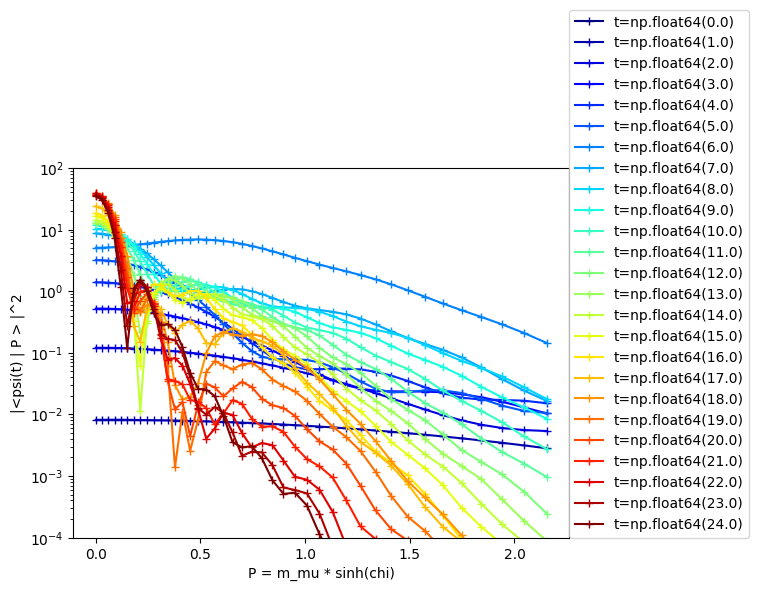

In [46]:
cm = plt.cm.jet
for t in ts:
    pr = [probs[t, chi] / probs_gs[t] for chi in chis]
    P = np.sinh(chis) * (E_ex - E_gs)
    plt.semilogy(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend(loc=(1, 0))
plt.ylim([1e-4, 1e2])

In [ ]:
cm = plt.cm.jet
for t in ts:
    pr = [probs[t, chi] / probs_gs[t] for chi in chis]
    P = np.sinh(chis) * (E_ex - E_gs)
    plt.semilogy(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend(loc=(1, 0))
plt.ylim([1e-4, 1e2])

In [ ]:
def trace_norm(psi0, psi1, Nc = 64):
    N = psi0.N
    N2 = N // 2
    s0 = N2 - Nc // 2
    s1 = N2 + Nc // 2


    psi0 = psi0.shallow_copy()
    psi1 = psi1.shallow_copy()

    for n in range(0, N2):
        psi0.orthogonalize_site_(n=n, to='last', normalize=True)
        psi0.absorb_central_(to='last')
        psi1.orthogonalize_site_(n=n, to='last', normalize=True)
        psi1.absorb_central_(to='last')

    for n in range(N-1, N2, -1):
        psi0.orthogonalize_site_(n=n, to='first', normalize=True)
        psi0.absorb_central_(to='first')
        psi1.orthogonalize_site_(n=n, to='first', normalize=True)
        psi1.absorb_central_(to='first')

    tmp = yastn.ncon([psi0[s0], psi1[s0]], [[-0, 1, -2], [-1, 1, -3]])
    for n in range(s0+1, s1):
        tmp = yastn.ncon([tmp, psi0[n], psi1[n]], [[-0, -1, 1, 3], [1, 2, -2], [3, 2, -3]])
    return np.abs(yastn.vdot(tmp, tmp).item())


In [ ]:
trace_norm(psi0, psi1, Nc = 64)